In [ ]:
from __future__ import annotations
from dataclasses import dataclass, field
from typing import Callable, Dict, Iterable, List, Optional, Sequence, Tuple, Set
import math
import numpy as np
from pprint import pprint
from dotenv import load_dotenv
import os
from pathlib import Path
import openai
import torch
from tqdm import tqdm
from collections import defaultdict

load_dotenv()
OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY")
OPENROUTER_BASE_URL = os.getenv("OPENROUTER_BASE_URL", "https://openrouter.ai/api/v1")

from src.clusterer import OnlineRelationClusterer
from src.redundancy_filter import RedundancyFilter
from src.kg import NXKnowledgeGraph
from src.pragma import PragmaticEquivalenceLearner
import networkx as nx

In [2]:
from model.openai_model import OpenAIModel

model = OpenAIModel(
    model_name="openai/gpt-4o-mini",
    base_url=OPENROUTER_BASE_URL,
    api_key=OPENROUTER_API_KEY,
    temperature=0.0
)

## Implementation

In [2]:
triplet_path = Path.cwd() / "output" / "webnlg" / "triplets.txt"
data_path = Path.cwd() / "data" / "webnlg.txt"

triplets_text = triplet_path.read_text().splitlines()

import ast
all_triplets = [ast.literal_eval(line) for line in triplets_text]

from model.openai_model import OpenAIModel
from src.agent import EntityTypingAgent

model = OpenAIModel(
    model_name="openai/gpt-4o-mini",
    base_url=OPENROUTER_BASE_URL,
    api_key=OPENROUTER_API_KEY,
    temperature=0.0
)
type_function_agent = EntityTypingAgent(
    llm=model,
)

type_function_agent.assign_type("Eiffel Tower")  # Example usage

'FACILITY'

In [3]:
from src.agent import TripletExtractionAgent, EntityTypingAgent
from src.embedding_generator import EmbeddingGenerator

def process_line(text, extractor, embedder, typer):
    """
    Runs:
    1) triple extraction
    2) embedding generation
    3) type assignment
    Returns array of dict objects, one per triple.
    """
    triples = extractor.extract(text)
    s_dct = {"sentence": text, "triples": triples}
    processed = []
    for h, r, t in triples:

        # Embedding from relation + the full sentence
        emb = embedder(r, text)
        # Type pair
        type_h = typer.assign_type(h)
        type_t = typer.assign_type(t)

        processed.append(
            {
                "head": h,
                "relation": r,
                "tail": t,
                "embedding": emb,
                "type_pair": (type_h, type_t)
            }
        )
    s_dct["data"] = processed
    return s_dct


def load_rebel_and_process(llm, path="data/rebel.txt"):
    path = Path(path)
    lines = path.read_text().splitlines()

    extractor = TripletExtractionAgent(llm)
    embedder = EmbeddingGenerator(llm)
    typer = EntityTypingAgent(llm)

    dataset = []

    for line in lines:
        samples = process_line(line, extractor, embedder, typer)
        dataset.extend(samples)

    return dataset

# data = load_rebel_and_process(None)

# for d in data[:5]:
#     print(d["head"], d["relation"], d["tail"], d["type_pair"])
#     print("Embedding shape:", d["embedding"].shape)
#     print()

In [ ]:
from src.agent import TripletExtractionAgent, EntityTypingAgent
from src.embedding_generator import EmbeddingGenerator

data_path = Path.cwd() / 'data' / 'webnlg.txt'
lines = data_path.read_text().splitlines()
print(len(lines))

client = openai.Client(
    api_key=OPENROUTER_API_KEY,
    base_url=OPENROUTER_BASE_URL,
)

extractor = TripletExtractionAgent(model)
embedder = EmbeddingGenerator(client)
typer = EntityTypingAgent(model)

sample_data = lines[:50]

1165


In [5]:
s_1_data = []
for line in tqdm(sample_data):
    samples = process_line(line, extractor, embedder, typer)
    s_1_data.append(samples)

print(len(s_1_data))

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [17:11<00:00, 20.63s/it] 

50


In [72]:
s_1_data[1]
import pickle
pickle.dump(s_1_data, open(Path.cwd() / "s1_data.pkl", "wb"))

s_1_data_test = pickle.load(open(Path.cwd() / "s1_data.pkl", "rb"))
len(s_1_data_test)

50

In [73]:
s_1_data[0]

{'sentence': 'The location of Trane is Swords, Dublin.',
 'triples': [('Trane', 'is located in', 'Swords, Dublin')],
 'data': [{'head': 'Trane',
   'relation': 'is located in',
   'tail': 'Swords, Dublin',
   'embedding': array([[-0.04717587,  0.07552741,  0.01546448, ..., -0.01930759,
            0.01091949, -0.01008528]], shape=(1, 1536), dtype=float32),
   'type_pair': ('ORG', 'LOCATION')}]}

In [ ]:

clusterer = OnlineRelationClusterer()

for sample in s_1_data:

    for t in sample["data"]:
        clusterer.process_triple(t)
print("Number of induced clusters:", len(clusterer.clusters))
print("Sample clusters:", clusterer.clusters[:3])

Number of induced clusters: 180
Sample clusters: [Cluster 0: 2 elements, Cluster 1: 2 elements, Cluster 2: 2 elements]


In [ ]:

learner = PragmaticEquivalenceLearner(mi_threshold=0.1, min_pairs=2)
equiv_classes, inverse_map = learner(clusterer)

print("Equivalence classes:", len(equiv_classes))
print("Inverse map:", len(inverse_map))

Equivalence classes: 30
Inverse map: 2


In [ ]:


kg = NXKnowledgeGraph()
rf = RedundancyFilter(kg, equiv_classes, inverse_map)

for (h, r_surface, t, cid) in clusterer.fact_list:
    added = rf.add_if_novel(h, cid, t, surface=r_surface)
    # print only if redundant
    if not added:
        print(["REDUNDANT", "ACCEPTED"][added], h, r_surface, t, "→ cluster", cid)

REDUNDANT Agremiação Sportiva Arapiraquense has 17000 members → cluster 51
REDUNDANT Agremiação Sportiva Arapiraquense plays in Campeonato Brasileiro Série C → cluster 52
REDUNDANT Nie Haisheng was born on October 13, 1964 → cluster 81
REDUNDANT Bionico is a food found in Mexico → cluster 86
REDUNDANT Hypermarcas founded on January 1, 2001 → cluster 99
REDUNDANT Bananaman is broadcasted by STV → cluster 113
REDUNDANT Alan Shepard was born in New Hampshire → cluster 121
REDUNDANT Alan Shepard died in California → cluster 123
REDUNDANT Liselotte Grschebina place of death Israel → cluster 126
REDUNDANT Ciudad Ayala is a part of Morelos → cluster 129
REDUNDANT Ciudad Ayala has a leader City Manager → cluster 130
REDUNDANT Pontiac Rageous made on the assembly line 1997 → cluster 138
REDUNDANT Adolfo Suarez Madrid-Barajas airport is operated by ENAIRE → cluster 140
REDUNDANT The Mason School of Business is located in Virginia → cluster 163
REDUNDANT The Mason School of Business is located in

In [66]:
for sample in s_1_data:
    if "Alan Shepard" in sample["sentence"]:
        print(sample["sentence"])
        pprint(sample["triples"])

Born in New Hampshire on November 18th 1923 and dying in California, Alan Shepard was a US national who was selected by NASA in 1959.
[('Alan Shepard', 'born in', 'New Hampshire'),
 ('Alan Shepard', 'died in', 'California'),
 ('Alan Shepard', 'was a', 'US national'),
 ('Alan Shepard', 'selected by', 'NASA'),
 ('NASA', 'selected', 'in 1959')]
Alan Shepard was an American test pilot who was born in New Hampshire in November of 1923. He died in California.
[('Alan Shepard', 'was', 'an American test pilot'),
 ('Alan Shepard', 'was born in', 'New Hampshire'),
 ('Alan Shepard', 'was born in', 'November of 1923'),
 ('Alan Shepard', 'died in', 'California')]


In [34]:
import json
import networkx as nx

def make_graphml_safe(G):
    """
    Returns a deep-copied graph where all attributes 
    are GraphML-safe: strings, ints, floats, bools.
    """

    H = nx.DiGraph()

    for n, attrs in G.nodes(data=True):
        safe_attrs = {}
        for k, v in attrs.items():
            if isinstance(v, (set, list, dict)):
                safe_attrs[k] = json.dumps(list(v))
            else:
                safe_attrs[k] = v
        H.add_node(n, **safe_attrs)

    for u, v, attrs in G.edges(data=True):
        safe_attrs = {}
        for k, val in attrs.items():
            if isinstance(val, (set, list, dict)):
                safe_attrs[k] = json.dumps(list(val))
            else:
                safe_attrs[k] = val
        H.add_edge(u, v, **safe_attrs)

    return H

H = make_graphml_safe(kg.G)
nx.write_graphml(H, "knowledge_graph.graphml")


In [36]:
G = nx.read_graphml("knowledge_graph.graphml")

G.nodes(data=True)

NodeDataView({'Trane': {}, 'Swords, Dublin': {}, 'Ciudad Ayala': {}, 'Morelos': {}, '1604.0': {}, '1,777,539': {}, '-6': {}, 'council-manager government': {}, 'City Manager': {}, 'ALCO RS-3': {}, 'diesel-electric transmission': {}, '17068.8 millimeter long': {}, 'Alan B. Miller Hall': {}, 'Virginia, USA': {}, 'Robert A.M. Stern': {}, '101 Ukrop Way': {}, 'Mason School of Business': {}, 'Liselotte Grschebina': {}, 'Karlsruhe': {}, 'Israel': {}, 'Ethnic groups in Israel': {}, 'Arabs': {}, 'Agremiação Sportiva Arapiraquense': {}, 'Vica': {}, '17000 members': {}, 'Campeonato Brasileiro Série C': {}, 'Brazil': {}, 'Bananaman': {}, 'the 10th of March, 1983': {}, 'Steve Bright': {}, 'the BBC': {}, 'The 11th Mississippi Infantry Monument': {}, '2000': {}, 'the municipality of Gettysburg': {}, 'Pennsylvania': {}, 'Adams County': {}, 'USA': {}, 'a Contributing Property': {}, 'Cumberland County': {}, 'government type in France': {}, 'unitary state': {}, 'The College of William and Mary': {}, 'the

In [37]:
kg.G.nodes(data=True)

NodeDataView({'Trane': {}, 'Swords, Dublin': {}, 'Ciudad Ayala': {}, 'Morelos': {}, '1604.0': {}, '1,777,539': {}, '-6': {}, 'council-manager government': {}, 'City Manager': {}, 'ALCO RS-3': {}, 'diesel-electric transmission': {}, '17068.8 millimeter long': {}, 'Alan B. Miller Hall': {}, 'Virginia, USA': {}, 'Robert A.M. Stern': {}, '101 Ukrop Way': {}, 'Mason School of Business': {}, 'Liselotte Grschebina': {}, 'Karlsruhe': {}, 'Israel': {}, 'Ethnic groups in Israel': {}, 'Arabs': {}, 'Agremiação Sportiva Arapiraquense': {}, 'Vica': {}, '17000 members': {}, 'Campeonato Brasileiro Série C': {}, 'Brazil': {}, 'Bananaman': {}, 'the 10th of March, 1983': {}, 'Steve Bright': {}, 'the BBC': {}, 'The 11th Mississippi Infantry Monument': {}, '2000': {}, 'the municipality of Gettysburg': {}, 'Pennsylvania': {}, 'Adams County': {}, 'USA': {}, 'a Contributing Property': {}, 'Cumberland County': {}, 'government type in France': {}, 'unitary state': {}, 'The College of William and Mary': {}, 'the

In [44]:
import json

def normalize_attrs(attrs):
    """
    Convert GraphML-safe JSON string attributes back into Python objects.
    Keep scalars untouched.
    Sort lists so ordering differences don't matter.
    """
    norm = {}
    for k, v in attrs.items():
        if isinstance(v, str):
            try:
                parsed = json.loads(v)
                # Automatically convert arrays -> sorted tuple or set
                if isinstance(parsed, list) and len(parsed) > 0:
                    # sorted tuple for deterministic comparison
                    norm[k] = set(sorted(parsed))
                else:
                    norm[k] = parsed
            except json.JSONDecodeError:
                # keep as string
                norm[k] = v
        else:
            norm[k] = v
    return norm

def graphs_are_identical(G1, G2):
    # ---- Compare node sets ----
    if set(G1.nodes()) != set(G2.nodes()):
        print("Node sets differ!")
        return False

    # ---- Compare edge sets ----
    if set(G1.edges()) != set(G2.edges()):
        print("Edge sets differ!")
        return False

    # ---- Compare node attributes ----
    for n in G1.nodes():
        a1 = normalize_attrs(G1.nodes[n])
        a2 = normalize_attrs(G2.nodes[n])
        if a1 != a2:
            print(f"Node attributes differ at node {n}")
            print("Original:", a1)
            print("Loaded:  ", a2)
            return False

    # ---- Compare edge attributes ----
    for u, v in G1.edges():
        a1 = normalize_attrs(G1[u][v])
        a2 = normalize_attrs(G2[u][v])
        if a1 != a2:
            print(f"Edge attributes differ at edge {u}->{v}")
            print("Original:", a1)
            print("Loaded:  ", a2)
            print(type(a1["clusters"]), type(a2["clusters"]))
            return False

    return True

graphs_are_identical(kg.G, G)

True

In [45]:
print(len(kg.G.nodes()), len(kg.G.edges()))

190 168


## Metrics

In [42]:
from src.evaluate import (
    sample_kg_edges, 
    attach_provenance, 
    compute_precision,
    compute_semantic_coherence,
    compute_type_entropy,
    build_edge_sets,
    compute_inverse_alignment,
    cluster_level_reduction,
    degree_summary,
    get_top_hubs,
    component_entropy
)

### Results - Web NLG

In [4]:
import pickle

with open("output/output/webnlg/s_1_extracted.pkl", "rb") as f:
    step1_data = pickle.load(f)

kg = NXKnowledgeGraph("output/output/webnlg/final_kg.graphml")

In [5]:
from collections import defaultdict

provenance = defaultdict(list)

for entry in step1_data:
    sentence = entry["sentence"]
    for (h, r, t) in entry["triples"]:
        provenance[(h, r, t)].append(sentence)

In [8]:

sampled = sample_kg_edges(kg.G, k=200)
sampled[:3]

evaluation_set = attach_provenance(sampled, provenance)
evaluation_set[:3]

[{'head': 'granola',
  'tail': 'bionico',
  'clusters': '[3058]',
  'surface_forms': '["are ingredients in"]',
  'evidence_sentences': ['Chopped Fruits, sour cream, condensed milk, granola, shredded coconut and raisins are the main ingredients in bionico (a dessert) found in Mexico. The currency of Mexico is the peso inhabited by the Mexicans. Cookie is a type of dessert.',
   'Chopped fruits, sour cream, condensed milk, granola, shredded coconut and raisins are the main ingredients in bionico, a food found in Mexico.']},
 {'head': 'Alan B Miller Hall',
  'tail': 'Robert A. M. Stern',
  'clusters': '[3665]',
  'surface_forms': '["architect"]',
  'evidence_sentences': ['The architect of Alan B Miller Hall in Virginia is Robert A. M. Stern.']},
 {'head': 'Adams County, Pennsylvania',
  'tail': 'Carroll County, Maryland',
  'clusters': '[172]',
  'surface_forms': '["has"]',
  'evidence_sentences': ['The 11th Mississippi Infantry Monument, built 2000, is categorized as a Contributing Prope

In [9]:
from src.agent import EvaluationAgent

eval_agent = EvaluationAgent(model)
responses = []
for obj in tqdm(evaluation_set):
        resp = eval_agent.run({
            "head": obj["head"],
            "tail": obj["tail"],
            "sentences": " ".join(obj["evidence_sentences"][:10])
        })
        responses.append(resp)

100%|██████████| 200/200 [02:25<00:00,  1.37it/s]


In [20]:
for obj, resp in zip(evaluation_set, responses):
    if not resp.lower().startswith("yes"):
        print(f"Failed: {obj['head']} - {obj['surface_forms']} - {obj['tail']} \n {obj['evidence_sentences'][0]}")

Failed: Pennsylvania's Cumberland County - ["is to the north of"] - Adams County 
 The 11th Mississippi Infantry Monument, erected in 2000, is categorised as a contributing property. It stands in Adams County, Pennsylvania, USA, in the municipality of Gettysburg. Pennsylvania's Cumberland County is to the north of Adams County.
Failed: Mexico - ["is led by"] - Roberto Gil Zuarth 
 Ciudad Ayala is in the country of Mexico which is led by Roberto Gil Zuarth.
Failed: This book - ["followed by"] - The Two Towers 
 The Fellowship of the Ring belongs to the Fantasy literary genre. This book was released on July 29, 1954, followed by The Two Towers. George Allen & Unwin published it.
Failed: Adolfo Suarez Madrid-Barajas Airport - ["is located in"] - San Sebastian de los Reyes 
 Adolfo Suarez Madrid-Barajas Airport is located in Madrid, Paracuellos de Jarama, San Sebastian de los Reyes and Alcobendas. It is operated by ENAIRE, has a runway length of 3500 and is 610.0 metres above sea level.
Fa

In [11]:
metrics = compute_precision(responses)
metrics

{'correct': 177, 'total': 200, 'precision': 0.885}

In [21]:
step1_flat = []

for entry in step1_data:
    for d in entry["data"]:
        step1_flat.append(d)

print("Total triple instances:", len(step1_flat))
step1_flat[0]

clusterer = OnlineRelationClusterer()

for triple in step1_flat:
    clusterer.process_triple(triple)

print("Induced clusters:", len(clusterer.clusters))

Total triple instances: 3836
Induced clusters: 3832


In [25]:
embedding_map = {}

for entry in step1_data:
    for d in entry["data"]:
        embedding_map[(d["head"], d["relation"], d["tail"])] = d["embedding"]


semantic_coherence = compute_semantic_coherence(clusterer, embedding_map)
for k, v in semantic_coherence.items():
    if v > 0.0:
        print(f"Cluster {k}: Semantic Coherence = {v:.4f}")


Cluster 0: Semantic Coherence = 0.4636
Cluster 1: Semantic Coherence = 0.0439
Cluster 2: Semantic Coherence = 0.2163
Cluster 10: Semantic Coherence = 0.0232


In [26]:

type_entropy = compute_type_entropy(clusterer)
counts = {0: 0, 1: 0, 2: 0}
for k, v in type_entropy.items():
    counts[v] += 1
counts

{0: 3830, 1: 2, 2: 0}

In [27]:
import pandas as pd

df = pd.DataFrame({
    "cluster_id": list(semantic_coherence.keys()),
    "semantic_coherence": list(semantic_coherence.values()),
    "type_entropy": [type_entropy[cid] for cid in semantic_coherence]
})

df.sort_values("semantic_coherence", ascending=False)
df.head(10)

,cluster_id,semantic_coherence,type_entropy
0,0,0.463574,1.0
1,1,0.043940,-0.0
2,2,0.216328,1.0
3,3,0.000000,-0.0
4,4,0.000000,-0.0
5,5,0.000000,-0.0
6,6,0.000000,-0.0
7,7,0.000000,-0.0
8,8,0.000000,-0.0
9,9,0.000000,-0.0


In [28]:
peq = PragmaticEquivalenceLearner(mi_threshold=0.25, min_pairs=2)
equiv_classes, inverse_map = peq.compute(clusterer)

inverse_map

{3: 3592,
 131: 3408,
 266: 3408,
 277: 3408,
 561: 3408,
 676: 3408,
 1626: 3408,
 1661: 3408,
 2219: 3408,
 2236: 3408,
 2375: 3408,
 3359: 3408,
 3407: 3408,
 3507: 3408,
 3586: 3408,
 3592: 3408,
 7: 3695,
 1654: 3234,
 3695: 3234,
 9: 1800,
 1800: 1240,
 12: 965,
 965: 2932,
 22: 2844,
 274: 22,
 455: 22,
 698: 22,
 2844: 22,
 25: 3776,
 3776: 273,
 27: 2473,
 2473: 3190,
 44: 3801,
 326: 3271,
 588: 3271,
 1179: 3271,
 1283: 3271,
 1507: 3271,
 2692: 3271,
 2810: 3271,
 2856: 3271,
 3515: 3271,
 3619: 3271,
 3801: 3271,
 46: 3564,
 3564: 46,
 48: 3395,
 1616: 2698,
 3136: 2698,
 3395: 2698,
 51: 2207,
 2207: 51,
 54: 1382,
 625: 3208,
 839: 3208,
 1382: 3208,
 80: 2568,
 2568: 3463,
 97: 2392,
 2392: 3831,
 256: 3592,
 632: 3592,
 789: 3592,
 792: 3592,
 1477: 3592,
 3408: 3592,
 134: 750,
 750: 3321,
 141: 3395,
 157: 627,
 627: 3797,
 171: 362,
 362: 3667,
 172: 3683,
 377: 3682,
 1633: 3682,
 2897: 3682,
 3189: 3682,
 3683: 3682,
 173: 3683,
 198: 2392,
 202: 3801,
 211: 3200,

In [29]:
E = build_edge_sets(clusterer)
inverse_alignment_scores = compute_inverse_alignment(E, inverse_map)
inverse_alignment_scores

{(3, 3592): 1.0,
 (131, 3408): 1.0,
 (266, 3408): 1.0,
 (277, 3408): 1.0,
 (561, 3408): 1.0,
 (676, 3408): 1.0,
 (1626, 3408): 1.0,
 (1661, 3408): 1.0,
 (2219, 3408): 1.0,
 (2236, 3408): 1.0,
 (2375, 3408): 1.0,
 (3359, 3408): 1.0,
 (3407, 3408): 1.0,
 (3507, 3408): 1.0,
 (3586, 3408): 1.0,
 (3592, 3408): 1.0,
 (7, 3695): 1.0,
 (1654, 3234): 1.0,
 (3695, 3234): 1.0,
 (9, 1800): 1.0,
 (1800, 1240): 1.0,
 (12, 965): 1.0,
 (965, 2932): 1.0,
 (22, 2844): 1.0,
 (274, 22): 1.0,
 (455, 22): 1.0,
 (698, 22): 1.0,
 (2844, 22): 1.0,
 (25, 3776): 1.0,
 (3776, 273): 1.0,
 (27, 2473): 1.0,
 (2473, 3190): 1.0,
 (44, 3801): 1.0,
 (326, 3271): 1.0,
 (588, 3271): 1.0,
 (1179, 3271): 1.0,
 (1283, 3271): 1.0,
 (1507, 3271): 1.0,
 (2692, 3271): 1.0,
 (2810, 3271): 1.0,
 (2856, 3271): 1.0,
 (3515, 3271): 1.0,
 (3619, 3271): 1.0,
 (3801, 3271): 1.0,
 (46, 3564): 1.0,
 (3564, 46): 1.0,
 (48, 3395): 1.0,
 (1616, 2698): 1.0,
 (3136, 2698): 1.0,
 (3395, 2698): 1.0,
 (51, 2207): 1.0,
 (2207, 51): 1.0,
 (54, 1382

In [30]:
N_raw = 0
for entry in step1_data:
    N_raw += len(entry["triples"])

N_final = kg.G.number_of_edges()
reduction = 1 - (N_final / N_raw)
{
    "raw_triples": N_raw,
    "final_edges": N_final,
    "reduction_rate": reduction
}

{'raw_triples': 3836,
 'final_edges': 1673,
 'reduction_rate': 0.5638686131386861}

In [31]:

cluster_reduction = cluster_level_reduction(clusterer, kg.G)
for k, v in list(cluster_reduction.items())[:5]:
    print(f"Cluster {k}: {v}")

Cluster 0: {'raw': 2, 'final': 2, 'reduction': 0.0}
Cluster 1: {'raw': 2, 'final': 2, 'reduction': 0.0}
Cluster 2: {'raw': 2, 'final': 2, 'reduction': 0.0}
Cluster 3: {'raw': 1, 'final': 1, 'reduction': 0.0}
Cluster 4: {'raw': 1, 'final': 1, 'reduction': 0.0}


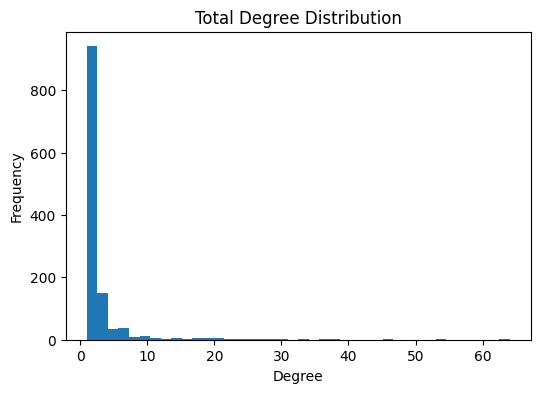

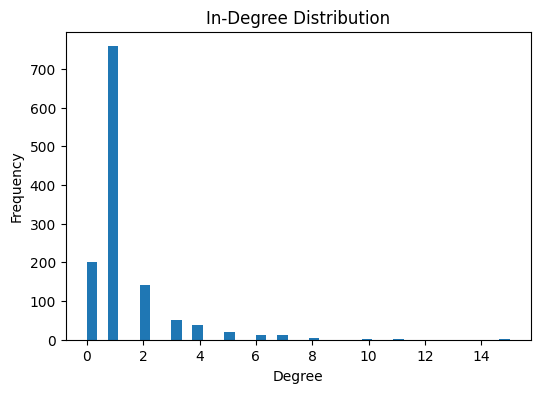

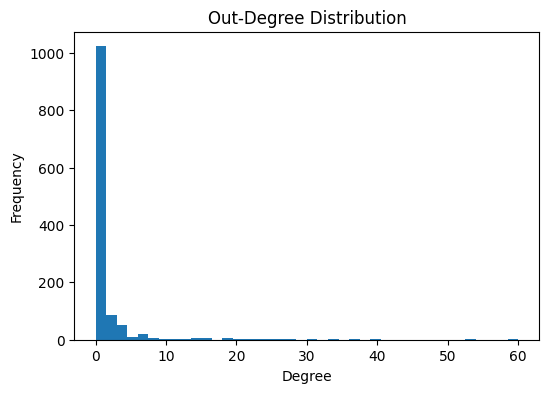

In [32]:
# Degree (undirected sense)
degrees = [deg for _, deg in kg.G.degree()]

# Directed in/out degrees
in_degrees = [deg for _, deg in kg.G.in_degree()]
out_degrees = [deg for _, deg in kg.G.out_degree()]

import matplotlib.pyplot as plt

def plot_degree_hist(data, title):
    plt.figure(figsize=(6,4))
    plt.hist(data, bins=40)
    plt.title(title)
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.show()

plot_degree_hist(degrees, "Total Degree Distribution")
plot_degree_hist(in_degrees, "In-Degree Distribution")
plot_degree_hist(out_degrees, "Out-Degree Distribution")

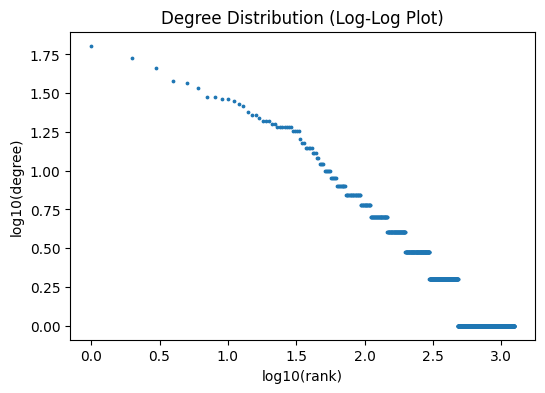

In [33]:
def plot_loglog(data, title):
    data = np.array(data)
    data = data[data > 0]   # log can't take zeros
    
    plt.figure(figsize=(6,4))
    plt.scatter(np.log10(np.arange(1, len(data)+1)),
                np.log10(np.sort(data)[::-1]),
                s=3)
    plt.title(title + " (Log-Log Plot)")
    plt.xlabel("log10(rank)")
    plt.ylabel("log10(degree)")
    plt.show()

plot_loglog(degrees, "Degree Distribution")

In [34]:
summary_total = degree_summary(degrees)
summary_in = degree_summary(in_degrees)
summary_out = degree_summary(out_degrees)

summary_total, summary_in, summary_out

({'min': 1,
  'max': 64,
  'mean': 2.702746365105008,
  'median': 1.0,
  'p90': 5.0,
  'p99': 25.259999999999764},
 {'min': 0,
  'max': 15,
  'mean': 1.351373182552504,
  'median': 1.0,
  'p90': 3.0,
  'p99': 7.0},
 {'min': 0,
  'max': 60,
  'mean': 1.351373182552504,
  'median': 0.0,
  'p90': 3.0,
  'p99': 22.259999999999764})

In [35]:
get_top_hubs(kg, n=20)

[('Ciudad Ayala', 64),
 ('Alan Shepard', 53),
 ('Bionico', 46),
 ('Liselotte Grschebina', 38),
 ('Hypermarcas', 37),
 ('Aaron Turner', 34),
 ('The University of Burgundy', 30),
 ('Acharya Institute of Technology', 30),
 ('Alan B. Miller Hall', 29),
 ('Mexico', 29),
 ('Agremiação Sportiva Arapiraquense', 28),
 ('Bananaman', 27),
 ('Nie Haisheng', 26),
 ('Abraham A. Ribicoff', 24),
 ('The Acharya Institute of Technology', 23),
 ('Alan B Miller Hall', 23),
 ('Adams County', 22),
 ('GMA New Media', 21),
 ('Adolfo Suárez Madrid–Barajas Airport', 21),
 ('The Fellowship of the Ring', 21)]

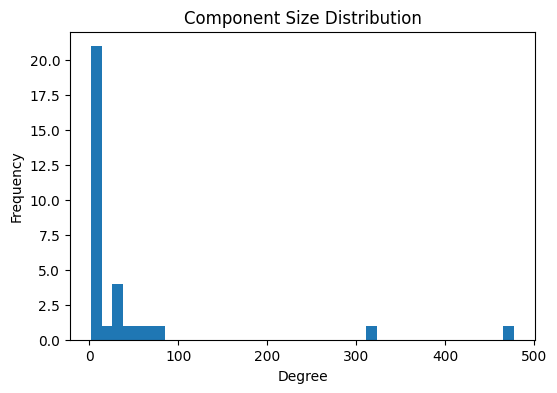

In [37]:

components = list(nx.connected_components(kg.G.to_undirected()))
component_sizes = [len(c) for c in components]

plot_degree_hist(component_sizes, "Component Size Distribution")


In [39]:
from collections import Counter

entity_type_counts = defaultdict(Counter)

for entry in step1_data:
    for d in entry["data"]:
        h = d["head"]
        t = d["tail"]
        th, tt = d["type_pair"]
        entity_type_counts[h][th] += 1
        entity_type_counts[t][tt] += 1

entity_type_map = {}
for ent, counter in entity_type_counts.items():
    entity_type_map[ent] = counter.most_common(1)[0][0]

print(len(entity_type_map))

def get_type(ent):
    return entity_type_map.get(ent, "OTHER")

G_undirected = kg.G.to_undirected()
components = list(nx.connected_components(G_undirected))
print("Number of components:", len(components))
components_sorted = sorted(components, key=lambda c: len(c), reverse=True)



component_stats = []

for i, comp in enumerate(components_sorted):
    ent, counts = component_entropy(comp, get_type)
    component_stats.append({
        "component_id": i,
        "size": len(comp),
        "entropy_bits": ent,
        "type_distribution": counts
    })

component_stats[:5]

1238
Number of components: 32


[{'component_id': 0,
  'size': 477,
  'entropy_bits': 3.2919297486491224,
  'type_distribution': Counter({'GPE': 97,
           'OTHER': 69,
           'ORG': 67,
           'DATE': 54,
           'PERSON': 52,
           'FACILITY': 38,
           'QUANTITY': 25,
           'NORP': 17,
           'LOCATION': 16,
           'EVENT': 16,
           'PRODUCT': 15,
           'MONEY': 6,
           'WORK_OF_ART': 5})},
 {'component_id': 1,
  'size': 317,
  'entropy_bits': 3.1902271197747165,
  'type_distribution': Counter({'OTHER': 93,
           'QUANTITY': 43,
           'GPE': 40,
           'FACILITY': 38,
           'PERSON': 18,
           'TIME': 16,
           'WORK_OF_ART': 13,
           'ORG': 11,
           'PRODUCT': 11,
           'MONEY': 10,
           'DATE': 9,
           'NORP': 8,
           'LOCATION': 7})},
 {'component_id': 2,
  'size': 75,
  'entropy_bits': 3.1206149285152764,
  'type_distribution': Counter({'NORP': 14,
           'DATE': 14,
           'GPE': 13,


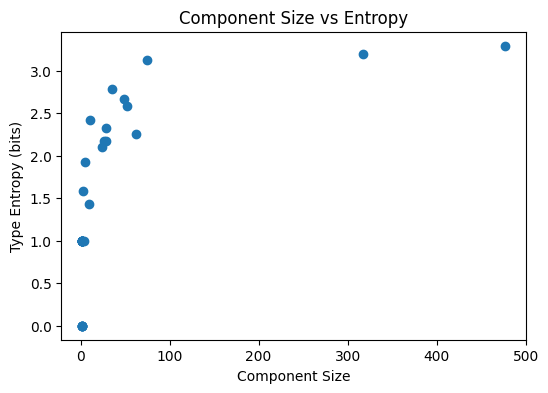

In [40]:

sizes = [c["size"] for c in component_stats]
entropies = [c["entropy_bits"] for c in component_stats]

plt.figure(figsize=(6,4))
plt.scatter(sizes, entropies)
plt.xlabel("Component Size")
plt.ylabel("Type Entropy (bits)")
plt.title("Component Size vs Entropy")
plt.show()

In [41]:
for comp in component_stats[:10]:
    print(f"Component {comp['component_id']}: size={comp['size']}, entropy={comp['entropy_bits']:.3f}")
    print("  Top types:", comp["type_distribution"].most_common(5))
    print()

Component 0: size=477, entropy=3.292
  Top types: [('GPE', 97), ('OTHER', 69), ('ORG', 67), ('DATE', 54), ('PERSON', 52)]

Component 1: size=317, entropy=3.190
  Top types: [('OTHER', 93), ('QUANTITY', 43), ('GPE', 40), ('FACILITY', 38), ('PERSON', 18)]

Component 2: size=75, entropy=3.121
  Top types: [('NORP', 14), ('DATE', 14), ('GPE', 13), ('OTHER', 9), ('WORK_OF_ART', 6)]

Component 3: size=62, entropy=2.258
  Top types: [('QUANTITY', 26), ('OTHER', 15), ('GPE', 8), ('ORG', 5), ('PERSON', 4)]

Component 4: size=52, entropy=2.581
  Top types: [('DATE', 15), ('PERSON', 13), ('FACILITY', 8), ('WORK_OF_ART', 6), ('OTHER', 4)]

Component 5: size=49, entropy=2.664
  Top types: [('DATE', 18), ('LOCATION', 8), ('QUANTITY', 8), ('OTHER', 6), ('PERSON', 2)]

Component 6: size=35, entropy=2.785
  Top types: [('DATE', 9), ('OTHER', 8), ('ORG', 6), ('GPE', 4), ('TIME', 2)]

Component 7: size=29, entropy=2.169
  Top types: [('GPE', 11), ('EVENT', 7), ('DATE', 6), ('OTHER', 3), ('NORP', 1)]

Com

### Output - REBEL

In [ ]:
import pickle

with open("output/output/rebel/s_1_extracted.pkl", "rb") as f:
    step1_data = pickle.load(f)

kg = NXKnowledgeGraph()

clusterer = OnlineRelationClusterer()

for sample in step1_data:
    for t in sample["data"]:
        clusterer.process_triple(t)
learner = PragmaticEquivalenceLearner(mi_threshold=0.25, min_pairs=2)
equiv_classes, inverse_map = learner(clusterer)
rf = RedundancyFilter(kg, equiv_classes, inverse_map)

for (h, r_surface, t, cid) in clusterer.fact_list:
    added = rf.add_if_novel(h, cid, t, surface=r_surface)
    # print only if redundant
    if not added:
        print(["REDUNDANT", "ACCEPTED"][added], h, r_surface, t, "→ cluster", cid)
kg.save("output/output/rebel/final_kg.graphml")

In [ ]:
provenance = defaultdict(list)
for entry in step1_data:
    sentence = entry["sentence"]
    for (h, r, t) in entry["triples"]:
        provenance[(h, r, t)].append(sentence)

sampled = sample_kg_edges(kg.G, k=200)
evaluation_set = attach_provenance(sampled, provenance)

In [ ]:
from src.agent import EvaluationAgent

eval_agent = EvaluationAgent(model)
responses = []
for obj in tqdm(evaluation_set):
    resp = eval_agent.run({
        "head": obj["head"],
        "tail": obj["tail"],
        "sentences": " ".join(obj["evidence_sentences"][:10])
    })
    responses.append(resp)
for obj, resp in zip(evaluation_set, responses):
    if not resp.lower().startswith("yes"):
        print(f"Failed: {obj['head']} - {obj['surface_forms']} - {obj['tail']} \n {obj['evidence_sentences'][0]}")

In [ ]:
metrics = compute_precision(responses)
print(metrics)

step1_flat = []

for entry in step1_data:
    for d in entry["data"]:
        step1_flat.append(d)

print("Total triple instances:", len(step1_flat))
print("Induced clusters:", len(clusterer.clusters))

embedding_map = {}

for entry in step1_data:
    for d in entry["data"]:
        embedding_map[(d["head"], d["relation"], d["tail"])] = d["embedding"]


semantic_coherence = compute_semantic_coherence(clusterer, embedding_map)
for k, v in semantic_coherence.items():
    if v > 0.0:
        print(f"Cluster {k}: Semantic Coherence = {v:.4f}")

type_entropy = compute_type_entropy(clusterer)
counts = {0: 0, 1: 0, 2: 0}
for k, v in type_entropy.items():
    counts[v] += 1
print(counts)

In [ ]:
df = pd.DataFrame({
    "cluster_id": list(semantic_coherence.keys()),
    "semantic_coherence": list(semantic_coherence.values()),
    "type_entropy": [type_entropy[cid] for cid in semantic_coherence]
})

df.sort_values("semantic_coherence", ascending=False)
df.head(10)

In [ ]:
E = build_edge_sets(clusterer)
inverse_alignment_scores = compute_inverse_alignment(E, inverse_map)
print(inverse_alignment_scores)

N_raw = 0
for entry in step1_data:
    N_raw += len(entry["triples"])

N_final = kg.G.number_of_edges()
reduction = 1 - (N_final / N_raw)
print({
    "raw_triples": N_raw,
    "final_edges": N_final,
    "reduction_rate": reduction
})

In [ ]:
# Degree (undirected sense)
degrees = [deg for _, deg in kg.G.degree()]

# Directed in/out degrees
in_degrees = [deg for _, deg in kg.G.in_degree()]
out_degrees = [deg for _, deg in kg.G.out_degree()]

import matplotlib.pyplot as plt

def plot_degree_hist(data, title):
    plt.figure(figsize=(6,4))
    plt.hist(data, bins=40)
    plt.title(title)
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.show()

plot_degree_hist(degrees, "Total Degree Distribution")
plot_degree_hist(in_degrees, "In-Degree Distribution")
plot_degree_hist(out_degrees, "Out-Degree Distribution")

In [ ]:
def plot_loglog(data, title):
    data = np.array(data)
    data = data[data > 0]   # log can't take zeros
    
    plt.figure(figsize=(6,4))
    plt.scatter(np.log10(np.arange(1, len(data)+1)),
                np.log10(np.sort(data)[::-1]),
                s=3)
    plt.title(title + " (Log-Log Plot)")
    plt.xlabel("log10(rank)")
    plt.ylabel("log10(degree)")
    plt.show()

plot_loglog(degrees, "Degree Distribution")

In [ ]:
summary_total = degree_summary(degrees)
summary_in = degree_summary(in_degrees)
summary_out = degree_summary(out_degrees)

summary_total, summary_in, summary_out

In [ ]:
get_top_hubs(kg, n=20)

In [ ]:

components = list(nx.connected_components(kg.G.to_undirected()))
component_sizes = [len(c) for c in components]

plot_degree_hist(component_sizes, "Component Size Distribution")

In [ ]:

entity_type_counts = defaultdict(Counter)

for entry in step1_data:
    for d in entry["data"]:
        h = d["head"]
        t = d["tail"]
        th, tt = d["type_pair"]
        entity_type_counts[h][th] += 1
        entity_type_counts[t][tt] += 1

entity_type_map = {}
for ent, counter in entity_type_counts.items():
    entity_type_map[ent] = counter.most_common(1)[0][0]

print(len(entity_type_map))

def get_type(ent):
    return entity_type_map.get(ent, "OTHER")

G_undirected = kg.G.to_undirected()
components = list(nx.connected_components(G_undirected))
print("Number of components:", len(components))
components_sorted = sorted(components, key=lambda c: len(c), reverse=True)



component_stats = []

for i, comp in enumerate(components_sorted):
    ent, counts = component_entropy(comp, get_type)
    component_stats.append({
        "component_id": i,
        "size": len(comp),
        "entropy_bits": ent,
        "type_distribution": counts
    })

component_stats[:5]

In [ ]:

sizes = [c["size"] for c in component_stats]
entropies = [c["entropy_bits"] for c in component_stats]

plt.figure(figsize=(6,4))
plt.scatter(sizes, entropies)
plt.xlabel("Component Size")
plt.ylabel("Type Entropy (bits)")
plt.title("Component Size vs Entropy")
plt.show()

In [ ]:
for comp in component_stats[:10]:
    print(f"Component {comp['component_id']}: size={comp['size']}, entropy={comp['entropy_bits']:.3f}")
    print("  Top types:", comp["type_distribution"].most_common(5))
    print()